In [1]:
import time

#importing the libraries for processing the data
import dask; print('Dask Version:', dask.__version__)
import dask_cudf
import cudf; print('cuDF Version:', cudf.__version__)
import pandas as pd; print('Pandas Version:', pd.__version__)
from numba import cuda
import cupy as cp
from numba import cuda

#importing the libries for the classification in cuml
import cuml; print('cuML Version:', cuml.__version__)
from cuml import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression
from cuml.decomposition import PCA as PCA_GPU
cuml.set_global_output_type('numpy')
from cuml import PCA

#import library 
import numpy as np

#importing libaries from sklearn for the classification and managing the data 
import sklearn
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as sklRF
from sklearn.linear_model import LogisticRegression as logis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#importing libaries for plotting graphs and maps
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

#overpass warning errors
import warnings
cuml.set_global_output_type('numpy')
warnings.filterwarnings('ignore')

%matplotlib inline

Dask Version: 2021.01.0
cuDF Version: 0.18.0a+172.g835ccf9c11
Pandas Version: 1.1.5
cuML Version: 0.18.0a+63.gae7e4442a


In [2]:
df = dask_cudf.read_csv("Partical.csv" , names =["Label", "lepton pT", "lepton eta", "lepton phi", "missing energy magnitude", "missing energy phi", 
        "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", 
        "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
        "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj",
        "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"], chunksize= '2000 Mib')

I loaded the dataset by using dask_cudf becuase with cudf_read.csv the dataset was too large to fit into  this machine memory. A name was given to the columns. I also decided to break up the datasetin array) into chunks to 2 gb.

In [3]:
df = df.sample(frac=0.5)

This code is about passing only the 50% of the dataset. This was done because the dataset is huge and it can not fit in the machine memory.

In [4]:
type(df)

dask_cudf.core.DataFrame

In [5]:
df = df.compute()

in this code, i compute the original dataset so now instead of working dask and i can start working rapids and cudf.

In [6]:
type(df)

cudf.core.dataframe.DataFrame

now the type of the dataset is in cudf dataframe

In [7]:
df.head()

,Label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
2869095,1.0,0.740821,-0.266922,-0.082360,0.822232,-1.005514,0.257966,1.560577,0.021782,0.000000,...,2.412228,-1.370900,0.000000,0.801033,0.766706,0.986567,0.576853,0.637052,0.868691,0.933099
2869094,1.0,1.402033,1.197927,-1.026737,0.957519,-0.395620,0.851581,-0.313928,0.577266,2.173076,...,-0.028777,0.906565,0.000000,0.787752,0.805812,0.985856,1.097103,0.966760,1.060326,0.865942
2869093,1.0,1.051387,1.569984,-0.266574,1.552940,1.172384,0.498618,2.144812,1.724823,0.000000,...,1.040568,0.209040,3.101961,1.772606,1.087739,1.704331,1.174295,0.583654,0.846972,0.874266
2869092,1.0,0.847698,1.554400,-1.159349,1.059122,1.054662,0.869811,0.598073,-0.025997,2.173076,...,1.311236,0.847744,0.000000,0.657516,0.861909,1.196033,1.137441,1.196455,0.893821,0.861369
2869091,0.0,1.075544,1.011899,-1.131051,0.659690,-1.127343,1.318778,0.493109,0.203062,0.000000,...,1.584402,-1.578992,0.000000,0.348883,0.620397,0.989246,0.601878,0.560855,0.612318,0.647955


In [8]:
df.describe()

,Label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,...,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06,5.500001e+06
mean,5.296540e-01,9.916460e-01,2.460000e-04,3.200000e-04,9.987710e-01,3.200000e-05,9.909210e-01,-1.730000e-04,-1.660000e-04,9.999120e-01,...,1.100000e-05,-9.300000e-05,9.995720e-01,1.034355e+00,1.024840e+00,1.050506e+00,1.009794e+00,9.727570e-01,1.033081e+00,9.598460e-01
std,4.991200e-01,5.654390e-01,1.008624e+00,1.006383e+00,6.001820e-01,1.006345e+00,4.750970e-01,1.009475e+00,1.005944e+00,1.027807e+00,...,1.007692e+00,1.006521e+00,1.400061e+00,6.750180e-01,3.811900e-01,1.644180e-01,3.974130e-01,5.251490e-01,3.652410e-01,3.131500e-01
min,0.000000e+00,2.746970e-01,-2.434976e+00,-1.742508e+00,2.370000e-04,-1.743944e+00,1.375940e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,...,-2.497265e+00,-1.742691e+00,0.000000e+00,7.900900e-02,1.986760e-01,9.105600e-02,1.320060e-01,4.975700e-02,2.951120e-01,3.474430e-01
25%,0.000000e+00,5.907530e-01,-7.383220e-01,-8.713760e-01,5.769010e-01,-8.708860e-01,6.789010e-01,-6.882350e-01,-8.686510e-01,0.000000e+00,...,-7.133570e-01,-8.725890e-01,0.000000e+00,7.906070e-01,8.461430e-01,9.857500e-01,7.676650e-01,6.735120e-01,8.193810e-01,7.704290e-01
50%,1.000000e+00,8.535540e-01,9.200000e-04,4.170000e-04,8.918460e-01,6.000000e-06,8.947280e-01,-2.500000e-05,-4.960000e-04,1.086538e+00,...,3.720000e-04,-8.190000e-04,0.000000e+00,8.949360e-01,9.506070e-01,9.897770e-01,9.165470e-01,8.732450e-01,9.472760e-01,8.720030e-01
75%,1.000000e+00,1.236409e+00,7.382140e-01,8.715490e-01,1.293654e+00,8.714540e-01,1.170649e+00,6.871940e-01,8.683130e-01,2.173076e+00,...,7.132690e-01,8.716050e-01,3.101961e+00,1.024754e+00,1.083404e+00,1.020349e+00,1.142164e+00,1.138573e+00,1.140432e+00,1.059326e+00
max,1.000000e+00,1.167397e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,8.848616e+00,2.969674e+00,1.741454e+00,2.173076e+00,...,2.498009e+00,1.743372e+00,3.101961e+00,3.107619e+01,1.563786e+01,7.553898e+00,1.289145e+01,1.776285e+01,8.779915e+00,6.966903e+00


In [9]:
df.isnull()

,Label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
2869095,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2869094,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2869093,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2869092,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2869091,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405399,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
405400,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
405401,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
405402,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The dataset is clear, there are no messing data.

This section is about explorating the DataFrame by applying some visualisation with scatter plots. this will be donw using matplot and seaborn. So i will reconvert my dataframe into a different type of Dataframe.

In [10]:
pandas_df = df.to_pandas()
print(type(pandas_df))

<class 'pandas.core.frame.DataFrame'>


I will convert the dataframe into pandas dataframe so it more easier to work with libraries such as seaborn and matplot

In [11]:
pandas_df

,Label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
2869095,1.0,0.740821,-0.266922,-0.082360,0.822232,-1.005514,0.257966,1.560577,0.021782,0.000000,...,2.412228,-1.370900,0.000000,0.801033,0.766706,0.986567,0.576853,0.637052,0.868691,0.933099
2869094,1.0,1.402033,1.197927,-1.026737,0.957519,-0.395620,0.851581,-0.313928,0.577266,2.173076,...,-0.028777,0.906565,0.000000,0.787752,0.805812,0.985856,1.097103,0.966760,1.060326,0.865942
2869093,1.0,1.051387,1.569984,-0.266574,1.552940,1.172384,0.498618,2.144812,1.724823,0.000000,...,1.040568,0.209040,3.101961,1.772606,1.087739,1.704331,1.174295,0.583654,0.846972,0.874266
2869092,1.0,0.847698,1.554400,-1.159349,1.059122,1.054662,0.869811,0.598073,-0.025997,2.173076,...,1.311236,0.847744,0.000000,0.657516,0.861909,1.196033,1.137441,1.196455,0.893821,0.861369
2869091,0.0,1.075544,1.011899,-1.131051,0.659690,-1.127343,1.318778,0.493109,0.203062,0.000000,...,1.584402,-1.578992,0.000000,0.348883,0.620397,0.989246,0.601878,0.560855,0.612318,0.647955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405399,1.0,1.646167,-0.017586,0.843251,0.557262,0.292496,0.699604,-0.164404,-0.222246,1.086538,...,-0.224490,-0.956935,0.000000,0.776418,0.890487,0.982778,0.786405,0.746340,0.700029,0.670455
405400,0.0,1.007648,-1.379194,-0.841413,0.138057,0.488765,0.381086,1.256576,0.698674,0.000000,...,-0.374398,1.642933,3.101961,0.777131,0.882996,0.985921,0.682077,0.935568,0.831252,0.797216
405401,0.0,0.538596,-0.553268,0.786100,0.838622,-0.976548,1.244667,-0.027752,0.738034,2.173076,...,-0.162028,-0.227778,0.000000,0.719665,0.842854,0.985592,1.091248,1.524911,0.995544,0.939421
405402,0.0,0.833606,-1.375298,0.053128,1.836986,-0.275721,1.485961,0.001955,1.436547,2.173076,...,0.339331,0.787259,0.000000,2.070819,1.804063,0.991671,1.799846,1.983383,1.478031,1.338737


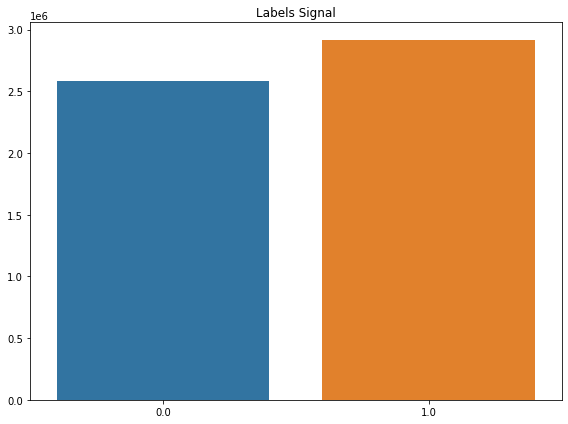

In [12]:
plt.figure(figsize=(8,6))
sns.barplot(x = pandas_df['Label'].value_counts().index, y = pandas_df['Label'].value_counts().values)
plt.title("Labels Signal")
plt.tight_layout()

This graph is about the signal label of the dataset(first feature), we can see that the dataset is nearly balanced(so it still unbalanced). The 1.0 label is equal to the signal process(which produces higgs boson) and 0.0 is equal to the background process(which does not produce higgs boson). 

We can now investgate on the features of the dataset by displaying a heat map. This can also lead us when it comes to decided which features to use for the training.

<AxesSubplot:>

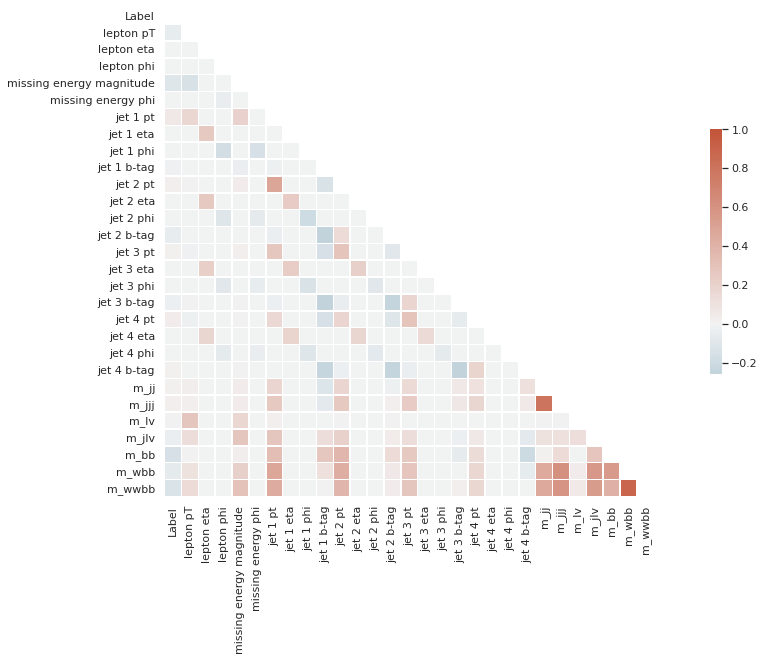

In [13]:
sns.set_theme(style="white")
corr = pandas_df.corr()
mask = np.triu(pandas_df.corr())
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pandas_df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This heat map shows us the all the features of the dataset. We can see that most features of the dataset are not correlated to the the output label. In fact only few features are nearly correlated but still not that relevant to remove them from the dataset. This heatmap technique can used also for feature selection needed for the training.So from this heatmap i learn that all the features can be pass in training.

TRAINING WITH CUML AND SKLEARN

This section regards the training purpose. Firstly i have already done the PCA(normally required lot of memory), but for memory purpose i decided to place it in the end of the notebook(the pca will be also used for the trainin purpose). 

In [14]:
X, y = df[df.columns.difference(['Label'])].fillna(value=0).as_matrix(), df['Label'].to_array()

Setting the independent variable. The X variables is be the all the features of dataset excluding the label feature. For y variable i pass the label feature in array.

In [15]:
scaler = StandardScaler()
scaler.fit(X)
x_scaled = scaler.transform(X)

Normalization of the X data for the training.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

the train and test split is about 80% for the train split and 20 % for the test split. I believe this ratio good because of the huge dataset.

In [17]:
X_train, X_test =X_train.astype(np.float32), X_test.astype(np.float32)

Turning the X variable to a np.float32 so i will be able to do the inference on the gpu(with most of cuml algorithms)

As the dataset is a classification dataset, the models that will be used to training will regard classification algorithhms. In this task rapids(cuml) is required. According to nvidia and rapids not all the traditional algorithms(sklearn) that we known are able to achieve a good result in rapids. In fact based on report of nvidia and rapids, I decided to use 2 algorithms that are able to achieve a good result in rapids and 1 that normally achieve an average result(based on nvidia and rapids report). So i will use Random forest and SVC (normally achive better result in both CUML AND SKLEARN) and logistic regression (average result in rapids). In addition i will also train these algorithms in sklearn to compare the benchmark between CPU anf GPU.

RANDOM FOREST GPU(cuml) AND CPU(sklearn)

In [18]:
cu_rf_params = {
'n_estimators': 25, 
'max_depth': 25,
'max_features': 'auto',
'n_bins': 200,  
'bootstrap': False,
'seed' : 0
}
cu_rf = cuRF(**cu_rf_params)

These are the best hyperparameters for cuml rfc (this will be also used for the sklearn rfc). The model does not improve from this hyperparameters. I used the the same for both to check out which performs better and has the better training/testing time.

In [19]:
tmp = time.time()
cu_rf.fit(X_train, y_train)
gpu_time = time.time() - tmp
print("CuMl Random Forest training Time: %s seconds" % (str(round(gpu_time,3))))

CuMl Random Forest training Time: 29.688 seconds


In [20]:
tmp = time.time()
y_pred = cu_rf.predict(X_test)
gpu_time = time.time() - tmp
print(cuml.metrics.accuracy_score(y_test, y_pred))
print("CuMl Random Forest Testing Time: %s seconds" % (str(round(gpu_time,3))))

0.7410011291503906
CuMl Random Forest Testing Time: 7.627 seconds


In [21]:
skl_rf_params = {
        'n_estimators': 25,
        'max_depth': 25,
        'random_state' : 0,
    }
skl_rf = sklRF( n_jobs=-1)

In [22]:
tmp = time.time()
skl_rf.fit(X_train, y_train)
cpu_time = time.time() - tmp
print("Sklearn Random Forest Training Time: %s seconds" % (str(round(cpu_time,3))))

Sklearn Random Forest Training Time: 286.794 seconds


In [23]:
tmp = time.time()
sk_preds = skl_rf.predict(X_test)
cpu_time = time.time() - tmp
print("Sklearn Random Forest Testing Time: %s seconds" % (str(round(cpu_time,3))))
print(sklearn.metrics.accuracy_score(y_test, sk_preds ))

Sklearn Random Forest Testing Time: 7.84 seconds
0.7479756836584694


EVALUATING THE BOTH MODELS(CUML AND SKLEARN)

In [24]:
tmp = time.time()
cu_preds = cu_rf.predict(X_test)
cu_conf_mat = confusion_matrix(y_test, cu_preds)
gpu_time = time.time() - tmp
print("CuMl RF confusion matrix Time: %s seconds" % (str(round(gpu_time,3))))
print(" CuMl RF confusion matrix : ")
print(cu_conf_mat)

CuMl RF confusion matrix Time: 1.601 seconds
 CuMl RF confusion matrix : 
[[373239 143909]
 [140990 441863]]


In [25]:
tmp = time.time()
print(classification_report(y_test,cu_preds, zero_division=1))
gpu_time = time.time() - tmp
print("CuMl RF classification_report Time: %s seconds" % (str(round(gpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72    517148
         1.0       0.75      0.76      0.76    582853

    accuracy                           0.74   1100001
   macro avg       0.74      0.74      0.74   1100001
weighted avg       0.74      0.74      0.74   1100001

CuMl RF classification_report Time: 1.711 seconds


These are about the confusion matrix and classification report of the Random Forest in rapids(CUML). We can see that the accuracy of the model is good(74%), The sensivity(which it refers as recall) report, we can see the detection is a bit better in 1.0 label(higgs boson) than in 0.0 label(noise signal), this can be maybe to the dataset which not is not full balanced. The sensivity give us the idea of how the model is good in detecting positive returns. I will return the AUC graph to determine if the model has performed weell.

In [26]:
auc_rfc_cuml = roc_auc_score(y_test, cu_preds)
print('AUC: %.3f' % auc_rfc_cuml)

AUC: 0.740


This is the accuracy of the model. So now we can display it on graph to get better knowlegde on how the model performed.

In [27]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, cu_preds)

Text(0.5, 0, 'Specificity')

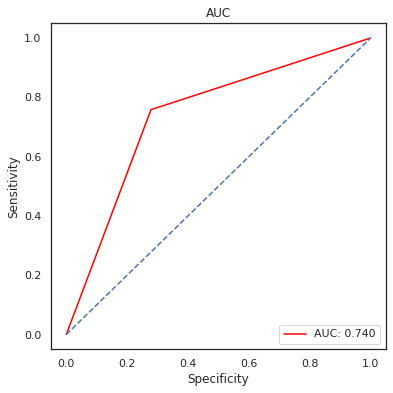

In [28]:
plt.figure(figsize=(6,6))
plt.title('AUC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC: %.3f' % auc_rfc_cuml)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')

This graph shows that the model(RF CUML) is alright and fair, which means that there is a high chance that the model will be albe to distinguish the two classes(label)

In [29]:
tmp = time.time()
sk_preds = skl_rf.predict(X_test)
cpu_time = time.time() - tmp
print(" Sklearn RF confusion matrix : ")
print(confusion_matrix(y_test,sk_preds))
print("Sklearn RF confusion matrix Testing Time: %s seconds" % (str(round(cpu_time,3))))

 Sklearn RF confusion matrix : 
[[377081 140067]
 [137160 445693]]
Sklearn RF confusion matrix Testing Time: 7.839 seconds


In [30]:
tmp = time.time()
print(classification_report(y_test,sk_preds, zero_division=1))
cpu_time = time.time() - tmp
print("Sklearn RF classification_report Time: %s seconds" % (str(round(cpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73    517148
         1.0       0.76      0.76      0.76    582853

    accuracy                           0.75   1100001
   macro avg       0.75      0.75      0.75   1100001
weighted avg       0.75      0.75      0.75   1100001

Sklearn RF classification_report Time: 1.752 seconds


This classification can be refered to the previous one in CUML because the accuracy, sensitivity and specificity are similar. 

In [31]:
auc_rfc_sk = roc_auc_score(y_test, sk_preds)
print('AUC: %.3f' % auc_rfc_sk)

AUC: 0.747


In [32]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, sk_preds)

Text(0.5, 0, 'Specificity')

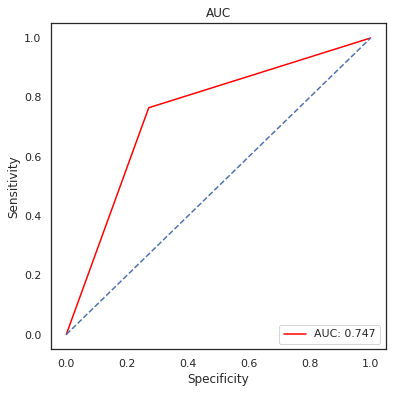

In [33]:
plt.figure(figsize=(6,6))
plt.title('AUC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC: %.3f' % auc_rfc_sk)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')

This graph shows that the model(RF Sklearn) is alright and fair, which means that there is a high chance that the model will be albe to distinguish the two classes(label)

SUPPORT VECTOR CLASSIFICATION

for this algorithm, the time required to train the dataset was too long, infact even the gpu(cuml) the training time was almost around 800 seconds which is too long for a gpu. I also tried to train the model on cpu(sklearn) and after 4 hours, the training was still processing. Even the result from this algorithm was not good.

LOGISTIC REGRESSION

In [34]:
tmp = time.time()
lr_cuml=LogisticRegression(C= 1000, max_iter= 10000, penalty= 'l2', solver= 'qn')
lr_cuml.fit(X_train, y_train)
gpu_time = time.time() - tmp
print("CuMl Logistic Regression training Time: %s seconds" % (str(round(gpu_time,3))))

CuMl Logistic Regression training Time: 1.265 seconds


In [35]:
tmp = time.time()
lr_pred = lr_cuml.predict(X_test)
gpu_time = time.time() - tmp
print(cuml.metrics.accuracy_score(y_test, lr_pred))
print("CuMl Logistic Regression Testing Time: %s seconds" % (str(round(gpu_time,3))))

0.6409448981285095
CuMl Logistic Regression Testing Time: 0.141 seconds


In [36]:
tmp = time.time()
logis= logis(C= 1000, max_iter= 10000, penalty= 'l2', solver= 'newton-cg')
logis.fit(X_train, y_train)
cpu_time = time.time() - tmp
print("Sklearn Logistic Regression training Time: %s seconds" % (str(round(cpu_time,3))))

Sklearn Logistic Regression training Time: 35.221 seconds


In [37]:
tmp = time.time()
logis_pred = logis.predict(X_test)
cpu_time = time.time() - tmp
print(sklearn.metrics.accuracy_score(y_test, logis_pred))
print("Sklearn Logistic Regression Testing Time: %s seconds" % (str(round(cpu_time,3))))

0.6412921442798688
Sklearn Logistic Regression Testing Time: 0.021 seconds


EVALUATING THE BOTH MODELS(CUML AND SKLEARN)

In [38]:
tmp = time.time()
lr_pred = lr_cuml.predict(X_test)
cu_conf_mat = confusion_matrix(y_test, lr_pred)
gpu_time = time.time() - tmp
print("CuMl LR confusion matrix Time: %s seconds" % (str(round(gpu_time,3))))
print("CuMl LR confusion matrix : ")
print(cu_conf_mat)

CuMl LR confusion matrix Time: 0.72 seconds
CuMl LR confusion matrix : 
[[272950 244198]
 [150763 432090]]


In [39]:
tmp = time.time()
print(classification_report(y_test,lr_pred, zero_division=1))
gpu_time = time.time() - tmp
print("CuMl LR classification_report Time: %s seconds" % (str(round(gpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58    517148
         1.0       0.64      0.74      0.69    582853

    accuracy                           0.64   1100001
   macro avg       0.64      0.63      0.63   1100001
weighted avg       0.64      0.64      0.64   1100001

CuMl LR classification_report Time: 1.693 seconds


In [40]:
auc_lr_cuml = roc_auc_score(y_test, lr_pred)
print('AUC: %.3f' % auc_lr_cuml)

AUC: 0.635


In [41]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lr_pred)

Text(0.5, 0, 'Specificity')

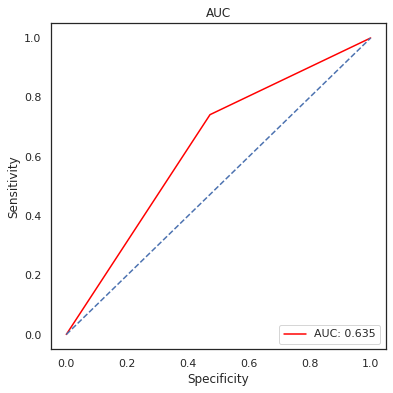

In [42]:
plt.figure(figsize=(6,6))
plt.title('AUC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC: %.3f' % auc_lr_cuml)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')

In [43]:
tmp = time.time()
logis_pred = logis.predict(X_test)
cpu_time = time.time() - tmp
print(" Sklearn con matri : ")
print(confusion_matrix(y_test,logis_pred))
print("Sklearn LR confusion matrix Testing Time: %s seconds" % (str(round(cpu_time,3))))

 Sklearn con matri : 
[[273152 243996]
 [150583 432270]]
Sklearn LR confusion matrix Testing Time: 0.029 seconds


In [44]:
tmp = time.time()
print(classification_report(y_test,logis_pred, zero_division=1))
cpu_time = time.time() - tmp
print("Sklearn LR classification_report Time: %s seconds" % (str(round(cpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58    517148
         1.0       0.64      0.74      0.69    582853

    accuracy                           0.64   1100001
   macro avg       0.64      0.63      0.63   1100001
weighted avg       0.64      0.64      0.64   1100001

Sklearn LR classification_report Time: 1.695 seconds


In [45]:
auc_lr_sk = roc_auc_score(y_test, logis_pred)
print('AUC: %.3f' % auc_lr_sk)

AUC: 0.635


In [46]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lr_pred)

Text(0.5, 0, 'Specificity')

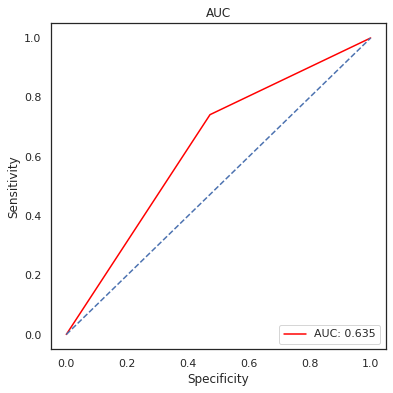

In [47]:
plt.figure(figsize=(6,6))
plt.title('AUC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC: %.3f' % auc_lr_sk)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')

COMPARE THE AUC SCORES

In [53]:
print("AUC SCORE BETWEEN THR CLASSIFICATION(CUML AND SKLEARN):")
print('RF CUML AUC SCORE: %.3f' % auc_rfc_cuml)
print('RF SKLEARN AUC SCORE: %.3f' % auc_rfc_sk)
print('LR CUML AUC SCORE: %.3f' % auc_lr_cuml )
print('LR SKLEARN AUC SCORE: %.3f' % auc_lr_sk)

AUC SCORE BETWEEN THR CLASSIFICATION(CUML AND SKLEARN):
RF CUML AUC SCORE: 0.740 %
RF SKLEARN AUC SCORE: 0.747 %
LR CUML AUC SCORE: 0.635 %
LR SKLEARN AUC SCORE: 0.635 %


RESULTS

The results from these two models(Random Forest and Logistic Regression) we can the difference between gpu(cuml) and cpu(sklearn) in terms of performing time, in fact comparing the first model(Random Forest) it shows that cuml tooks only 29.494 seconds to training the dataset against sklearn which tooks almost 290.193 seconds(almost 5 minutes) for the training. In terms of accuracy both models are very close(CUML = 0.74, SKLEARN = 0.75) so there is no gap between them. This is also proved in classifiation report ,the AUC score and AUC graph with similar values. So in general the main diffference is about the time between cuml and sklearn. On the other hand I also used Logistic regression for the training and comparing them(both cuml and sklearn) with Random Forest, we can noticed that the training time is less,(For cuml only 1.555 seconds, and for sklearn just 32.082 seconds) but comparing the accuracy and testing the values is worst, in fact both of them scored 0.64. Even the AUC graph shows that the model is not too good. A final consideration is about picking the right model, which will be used to compare with the results from pca data training. The model will be Random forest in rapids. 

PCA

Now i will apply pca on the origiinal dataset to reduce the dimension. With the dimension reduce, i will save data(pca data) and train it, and also to compare the results between the original dataset and pca dataset. 

In [11]:
feat = ["lepton pT", "lepton eta", "lepton phi", "missing energy magnitude", "missing energy phi", 
        "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", 
        "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
        "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj",
        "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]

Creating a variable

In [12]:
X = pandas_df.loc[:, feat].values
yy = pandas_df['Label'].values 

Setting the independent variable

In [13]:
scaler = StandardScaler()
scaler.fit(X)
x_scaled = scaler.transform(X)

Normalization of the X variable

In [14]:
x_scaled = pd.DataFrame(x_scaled)

In [15]:
x_scaled_cudf = cudf.DataFrame.from_pandas(x_scaled)

Coverting from the pandas dataframe to cudf dataframe. 

[W] [17:03:39.542241] Warning(`_build_params`): As of v0.16, PCA invoked without an n_components argument defauts to using min(n_samples, n_features) rather than 1


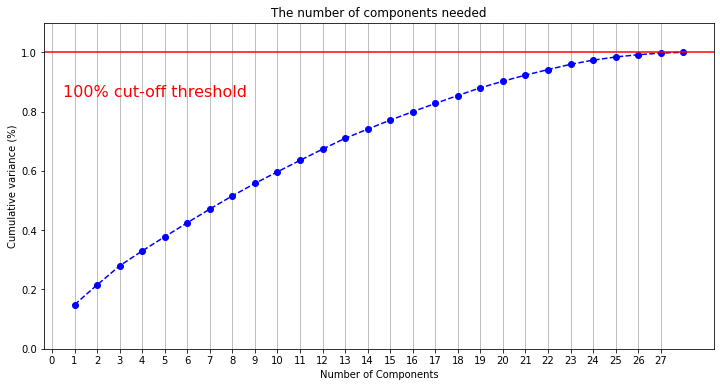

In [16]:
pca = PCA().fit(x_scaled_cudf)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 29, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 28, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed')

plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

This section is about investigation on the importance of the features, which will also lead into the dimensional reduction(pca). We can see that 100% of the information of the dataset is contain from the 25th feature up to the 28th. For this task i decided to use all the infromation(100) of the dataset, so for the pca i will set my n_components to 25(which is nearly 100%).

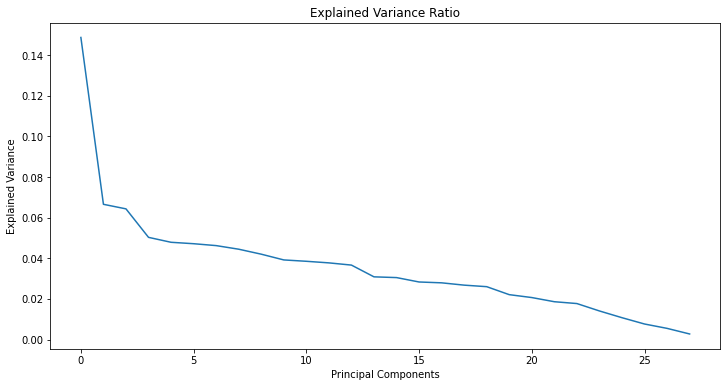

array([0.14872415, 0.06657891, 0.0643318 , 0.05030652, 0.04787667,
       0.04717513, 0.04624252, 0.04447018, 0.04202115, 0.03919037,
       0.03852236, 0.03773924, 0.03665178, 0.03086374, 0.03049652,
       0.02833065, 0.02791554, 0.02677562, 0.02602197, 0.02209076,
       0.02066551, 0.01861405, 0.01771141, 0.01406677, 0.01074936,
       0.00764028, 0.0054934 , 0.00273363])

In [17]:
plt.plot(range(0,28), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()
pca.explained_variance_ratio_

As is very difficult to rappresent 28 components on a pca graph, i decide to return the pca.explained_variance_ratio_ object, which is more easier to show on a two-dimensional graph. This graphs shows where the most of the information of the dataset is contain. 

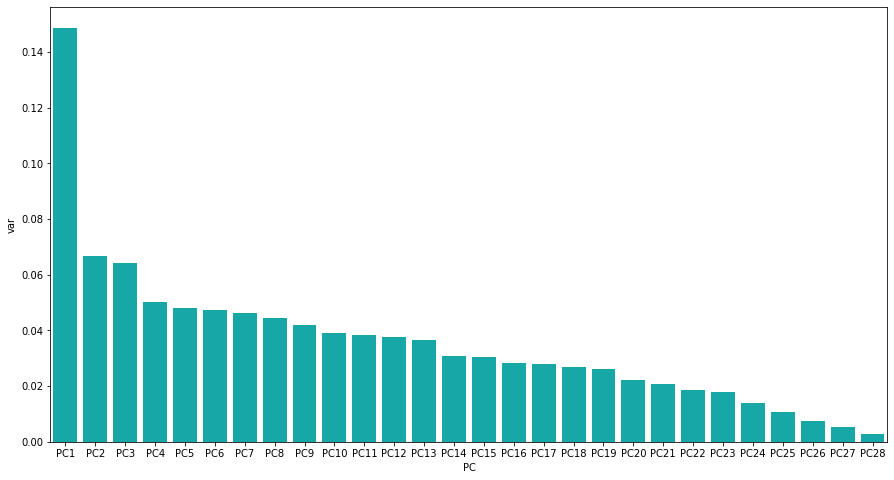

In [18]:
pca_data = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':["PC1", "PC2", "PC3", "PC4", "PC5", "PC6",
           "PC7", "PC8", "PC9", "PC10", "PC11", "PC12",
           "PC13", "PC14", "PC15", "PC16", "PC17", "PC18",
           "PC19",  "PC20", "PC21", "PC22", "PC23",
           "PC24", "PC25", "PC26", "PC27", "PC28"]})
plt.figure(figsize=(15,8))
ax = sns.barplot(x='PC',y="var", data=pca_data,  color='c');

This plot shows clearly how the information of pca variance is distrubed.

In [20]:
pca_gpu = PCA_GPU(n_components=25)

I decided to set my n_componens to 25 becuase according the previous operations, the 100% of the information is contained in up to the 25th feature.

In [21]:
pca_gpu.fit(x_scaled_cudf)
components_gpu = pca_gpu.transform(x_scaled_cudf)
components_gpu

array([[-1.96415336,  1.76066385, -0.74707023, ..., -0.5525216 ,
        -0.65320265,  0.77745185],
       [-0.5761554 ,  0.38402132,  1.74049991, ...,  0.35699683,
        -0.41945839, -0.19406334],
       [-0.0958208 ,  2.64503882, -0.8901239 , ...,  1.34042772,
         0.35832964, -0.53653126],
       ...,
       [-0.26515819,  0.62432199,  1.92375052, ..., -0.26770665,
         0.70357288, -0.01616201],
       [ 3.80088071, -1.58122936,  1.48942417, ...,  1.22310667,
         0.30248367, -1.31512746],
       [-0.50878858, -1.98757693,  0.01976379, ...,  0.50259192,
         0.13511803,  1.06632618]])

In [22]:
components_gpu.shape

(5500001, 25)

This is the shape after applying the pca(with gpu). The 28 principal components will contain the most of information from the original dataset.

In [23]:
pandas_df = cudf.DataFrame(components_gpu, columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6",
           "PC7", "PC8", "PC9", "PC10", "PC11", "PC12",
           "PC13", "PC14", "PC15", "PC16", "PC17", "PC18",
           "PC19",  "PC20", "PC21", "PC22", "PC23",
           "PC24", "PC25"])

In [24]:
pandas_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,-1.964153,1.760664,-0.747070,0.252116,1.887315,0.270997,0.309326,-0.075868,-0.469017,1.421609,...,-0.737102,-0.290454,0.297171,-1.258886,0.626395,0.227698,-0.382763,-0.552522,-0.653203,0.777452
1,-0.576155,0.384021,1.740500,-0.093920,-0.088229,-0.997152,-0.460611,-0.382071,0.504257,1.805403,...,-0.807582,-0.248147,-0.167485,0.945883,-0.271365,-0.605583,0.227929,0.356997,-0.419458,-0.194063
2,-0.095821,2.645039,-0.890124,-2.251195,-0.682610,0.680494,-2.788675,-1.296543,-0.350235,-0.838523,...,-0.655744,1.212388,1.088283,-0.031887,2.038655,-0.499807,0.343053,1.340428,0.358330,-0.536531
3,-0.398550,1.863880,0.701064,-0.078007,0.754616,1.556185,1.246507,-0.011947,0.075897,-0.231090,...,-0.228242,-0.021424,0.162826,0.846384,-0.536100,0.714938,0.138502,0.400129,0.232056,-0.225543
4,-2.215189,2.013669,-0.364618,1.080283,0.904778,1.076627,-0.520341,-1.524756,0.181185,-0.378495,...,0.354673,-0.076844,-0.270368,0.415847,-0.968753,0.020341,-0.319988,-1.603124,0.871299,0.335944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499996,-1.989542,-0.127545,-0.066712,-0.309847,1.580266,0.536635,0.402808,0.876258,1.070772,0.710399,...,-0.695719,-0.305309,-0.324547,-0.185165,-0.414855,0.306681,-0.192781,0.163383,-0.339930,-0.243608
5499997,-1.794679,-0.165636,-1.006112,0.455705,-1.569944,-1.169297,-0.899249,-0.626359,0.752626,0.515860,...,1.571933,-1.121320,1.100550,-1.291553,0.426613,0.817708,-0.639772,0.290045,0.014976,0.162574
5499998,-0.265158,0.624322,1.923751,0.366453,-0.087568,-0.936061,0.813575,-1.224564,-0.094494,-1.228852,...,0.996852,0.464224,-0.832509,-0.680105,0.291967,-0.243707,-0.146764,-0.267707,0.703573,-0.016162
5499999,3.800881,-1.581229,1.489424,-0.652160,-0.148411,-1.956577,0.051543,-1.239203,-0.817694,-0.481400,...,-1.409843,-0.005826,0.332608,-1.093523,-0.934953,0.322410,-0.045185,1.223107,0.302484,-1.315127


In [25]:
yy

array([1., 1., 1., ..., 0., 0., 1.])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.2)

In [27]:
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

Spliting the dataset same as done for the original dataset, i also set the X_train, X_test to np.float32 so i can run the testing on the gpu

In [28]:
X_test.shape

(1100001, 28)

TRAINING THE PCA DATA WITH RANDOM FOREST AND LOGISTIC REGRESSION

RANDOM FOREST

In [29]:
cu_rf_params = {
'n_estimators': 25, 
'max_depth': 25,
'max_features': 'auto',
'n_bins': 8,  
'bootstrap': False,
'seed' : 0
}
pca_cu_rf = cuRF(**cu_rf_params)

In [30]:
tmp = time.time()
pca_cu_rf.fit(X_train, y_train)
gpu_time = time.time() - tmp
print("CuMl PCA Random Forest training Time: %s seconds" % (str(round(gpu_time,3))))

CuMl PCA Random Forest training Time: 5.858 seconds


In [31]:
tmp = time.time()
cu_pca_preds = pca_cu_rf.predict(X_test)
gpu_time = time.time() - tmp
print(cuml.metrics.accuracy_score(y_test, cu_pca_preds))
print("CuMl Random Forest Testing Time: %s seconds" % (str(round(gpu_time,3))))

0.7284739017486572
CuMl Random Forest Testing Time: 13.768 seconds


In [32]:
skl_rf_params = {
        'n_estimators': 25,
        'max_depth': 25,
        'random_state' : 0,
    }
pca_skl_rf = sklRF( n_jobs=-1)

In [33]:
tmp = time.time()
pca_skl_rf.fit(X_train, y_train)
cpu_time = time.time() - tmp
print("Sklearn PCA Random Forest Training Time: %s seconds" % (str(round(cpu_time,3))))

Sklearn PCA Random Forest Training Time: 299.483 seconds


In [34]:
tmp = time.time()
sk_pca_preds = pca_skl_rf.predict(X_test)
cpu_time = time.time() - tmp
print("Sklearn PCA Random Forest Testing Time: %s seconds" % (str(round(cpu_time,3))))
print(sklearn.metrics.accuracy_score(y_test, sk_pca_preds ))

Sklearn PCA Random Forest Testing Time: 7.975 seconds
0.747522956797312


In [35]:
tmp = time.time()
cu_pca_preds = pca_cu_rf.predict(X_test)
cu_conf_mat = confusion_matrix(y_test, cu_pca_preds)
gpu_time = time.time() - tmp
print("CuMl PCA RF confusion matrix Time: %s seconds" % (str(round(gpu_time,3))))
print(" cuml con matri : ")
print(cu_conf_mat)

CuMl PCA RF confusion matrix Time: 2.231 seconds
 cuml con matri : 
[[368419 148976]
 [149703 432903]]


In [36]:
tmp = time.time()
print(classification_report(y_test,cu_pca_preds, zero_division=1))
gpu_time = time.time() - tmp
print("CuMl PCA RF classification_report Time: %s seconds" % (str(round(gpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71    517395
         1.0       0.74      0.74      0.74    582606

    accuracy                           0.73   1100001
   macro avg       0.73      0.73      0.73   1100001
weighted avg       0.73      0.73      0.73   1100001

CuMl PCA RF classification_report Time: 1.66 seconds


In [37]:
tmp = time.time()
sk_pca_preds = pca_skl_rf.predict(X_test)
cpu_time = time.time() - tmp
print(" Sklearn con matri : ")
print(confusion_matrix(y_test,sk_pca_preds))
print("Sklearn PCA RF confusion matrix Testing Time: %s seconds" % (str(round(cpu_time,3))))

 Sklearn con matri : 
[[377291 140104]
 [137621 444985]]
Sklearn PCA RF confusion matrix Testing Time: 7.839 seconds


In [38]:
tmp = time.time()
print(classification_report(y_test,sk_pca_preds, zero_division=1))
cpu_time = time.time() - tmp
print("Sklearn PCA RF classification_report Time: %s seconds" % (str(round(cpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73    517395
         1.0       0.76      0.76      0.76    582606

    accuracy                           0.75   1100001
   macro avg       0.75      0.75      0.75   1100001
weighted avg       0.75      0.75      0.75   1100001

Sklearn PCA RF classification_report Time: 1.652 seconds


RESULTS

After performing pca on the original dataset and reducing the dimension up to 25 (which is the endpoint where 100% of information is contain). The results shows no improving in accuracy in these two models(RF CUML AND SKLEARN) in comparition with the original data performance, for the sklearn both (original data and pca data) the accuracy is the same but in cuml the original data performs better than pca data. These results are very interesting, because it shows that on this dataset (pca) is not really improving as we can see in the accuracy. In relation with the time performing it looks like the pca training is  a bit fast(), most likely because there are less features. On the other classification(Logistic Regression),the results a very similar them the original dataset and the pca dataset. So overall the original dataset performs better.

LOGISTIC REGRESSION

In [39]:
tmp = time.time()
lr_pca_cuml=LogisticRegression(C= 1000, max_iter= 10000, penalty= 'l2', solver= 'qn')
lr_pca_cuml.fit(X_train, y_train)
gpu_time = time.time() - tmp
print("CuMl PCA Logistic Regression training Time: %s seconds" % (str(round(gpu_time,3))))

CuMl PCA Logistic Regression training Time: 0.999 seconds


In [40]:
tmp = time.time()
lr_pac_pred = lr_pca_cuml.predict(X_test)
gpu_time = time.time() - tmp
print(cuml.metrics.accuracy_score(y_test, lr_pac_pred))
print("CuMl PCA Logistic Regression Testing Time: %s seconds" % (str(round(gpu_time,3))))

0.6413066983222961
CuMl PCA Logistic Regression Testing Time: 0.136 seconds


In [41]:
tmp = time.time()
logis_pca= logis(C= 1000, max_iter= 10000, penalty= 'l2', solver= 'newton-cg')
logis_pca.fit(X_train, y_train)
cpu_time = time.time() - tmp
print("Sklearn PCA Logistic Regression training Time: %s seconds" % (str(round(cpu_time,3))))

Sklearn PCA Logistic Regression training Time: 34.272 seconds


In [42]:
tmp = time.time()
logis_pca_pred = logis_pca.predict(X_test)
cpu_time = time.time() - tmp
print(sklearn.metrics.accuracy_score(y_test, logis_pca_pred))
print("Sklearn PCA Logistic Regression Testing Time: %s seconds" % (str(round(cpu_time,3))))

0.6412248716137531
Sklearn PCA Logistic Regression Testing Time: 0.028 seconds


In [43]:
tmp = time.time()
lr_pca_pred = lr_pca_cuml.predict(X_test)
cu_conf_mat = confusion_matrix(y_test, lr_pca_pred)
gpu_time = time.time() - tmp
print("CuMl PCA LR confusion matrix Time: %s seconds" % (str(round(gpu_time,3))))
print(" cuml con matri : ")
print(cu_conf_mat)

CuMl PCA LR confusion matrix Time: 0.695 seconds
 cuml con matri : 
[[273715 243680]
 [150883 431723]]


In [44]:
tmp = time.time()
print(classification_report(y_test,lr_pca_pred, zero_division=1))
gpu_time = time.time() - tmp
print("CuMl PCA LR classification_report Time: %s seconds" % (str(round(gpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58    517395
         1.0       0.64      0.74      0.69    582606

    accuracy                           0.64   1100001
   macro avg       0.64      0.64      0.63   1100001
weighted avg       0.64      0.64      0.64   1100001

CuMl PCA LR classification_report Time: 1.646 seconds


In [45]:
tmp = time.time()
logis_pca_pred = logis_pca.predict(X_test)
cpu_time = time.time() - tmp
print(" Sklearn con matri : ")
print(confusion_matrix(y_test,logis_pca_pred))
print("Sklearn PCA LR confusion matrix Testing Time: %s seconds" % (str(round(cpu_time,3))))

 Sklearn con matri : 
[[273391 244004]
 [150649 431957]]
Sklearn PCA LR confusion matrix Testing Time: 0.022 seconds


In [46]:
tmp = time.time()
print(classification_report(y_test,logis_pca_pred, zero_division=1))
cpu_time = time.time() - tmp
print("Sklearn PCA LR classification_report Time: %s seconds" % (str(round(cpu_time,3))))

              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58    517395
         1.0       0.64      0.74      0.69    582606

    accuracy                           0.64   1100001
   macro avg       0.64      0.63      0.63   1100001
weighted avg       0.64      0.64      0.64   1100001

Sklearn PCA LR classification_report Time: 1.655 seconds


---------

RESULTS

After performing pca on the original dataset and reducing the dimension up to 25 (which is the endpoint where 100% of information is contain). The results shows no improving in accuracy in these two model(RF CUML AND SKLEARN) in comparition with the original data performance, for the sklearn both (original data and pca data) the accuracy is the same but in cuml the original data performs better than pca data. These results are well interesting, because it shows that on this dataset pca is not really as we the accuracy does not improved. In relation to time performing it looks like the pca training is  a bit fast, most likely because there are less features. On the other classification(Logistic Regression),the results a very similar them the original dataset and the pca dataset. So overall the original dataset performs better. As there is no improving the training and testing, i decided to not print out the AUC GRAPH becuase even just from the classification report we can understand that this training and testing(pca data) has not improved.

-----------

FINAL RESULTS AND DISCUSSION

For the final discussion, the discussion will focus on the original dataset. In fact as it is noticed previously, Random Forest in cuml is very fast for training in even on huge dataset in comparition with the one in sklearn, but on the other hand the results are pretty much the same. So my consideration is that the Random Forest is one of the best machine learning popular algoristms in Rapids becuase it is able to return a good model in just few seconds, and the accuracy are right. 

In [54]:
print("AUC SCORE BETWEEN THE CLASSIFICATION(CUML AND SKLEARN):")
print(('RF CUML AUC SCORE: %.3f' % auc_rfc_cuml),('%'))
print(('RF SKLEARN AUC SCORE: %.3f' % auc_rfc_sk),('%'))
print(('LR CUML AUC SCORE: %.3f' % auc_lr_cuml ),('%'))
print(('LR SKLEARN AUC SCORE: %.3f' % auc_lr_sk),('%'))

AUC SCORE BETWEEN THR CLASSIFICATION(CUML AND SKLEARN):
RF CUML AUC SCORE: 0.740 %
RF SKLEARN AUC SCORE: 0.747 %
LR CUML AUC SCORE: 0.635 %
LR SKLEARN AUC SCORE: 0.635 %


The others metrcis such classification report, confusion matrix, and auc graph are shown in the first training section. I decided to not perform the metrcis on the pca training because i believe there are not good as the original ones 